### [Disclaimer] Attention this notebook is brouillion, you enter at your own risk!

In [1]:
%load_ext autoreload
%autoreload 2

import os, codecs, string, random
import numpy as np
import pandas as pd

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models

#handle str lib
import re

import matplotlib.pyplot as plt

pd.set_option('max_colwidth', 1000)

#The data
advBeer_root = 'DATA/BeerAdvocate/'
df_adv_breweries = pd.read_csv(advBeer_root + 'breweries.csv')
df_adv_users = pd.read_csv(advBeer_root + 'users.csv')

C:\Users\xavie\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_adv_users.head()

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
0,7820,465,nmann08.184925,nmann08,1.199704e+09,"United States, Washington"
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York"
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,1.101380e+09,Northern Ireland
4,604,604,cypressbob.3708,cypressbob,1.069326e+09,Northern Ireland


### helpers functions

In [3]:
def get_location_user(x, review):
    """
    This function return the location of a user with using his/her location in the review list
    input: x (user_id, type 'str'), review (dataframe with columns:user_id, location, dtypes object)
    output: location value of the user_id (type: np.array.values, value type 'str')
    """
    #print(x, type(x))
    location =  review.loc[review['user_id'] == x,'location'].values 
    
    # location is a np.array, we just return the value in this array    
    return location[0]

In [4]:
# code took from homework 1 
import requests
import re

positive_word_document = requests.get("https://ptrckprry.com/course/ssd/data/positive-words.txt")
negative_word_document = requests.get("https://ptrckprry.com/course/ssd/data/negative-words.txt")

positive_words = re.search(r'(?<=;[\r\n]{2}).*',positive_word_document.text,re.DOTALL).group(0).split()
negative_words = re.search(r'(?<=;[\r\n]{2}).*',negative_word_document.text,re.DOTALL).group(0).split()

#dictionary of sentiment words
sentiment_dict = {
    "positive" : positive_words,
    "negative" : negative_words
}

In [48]:
def indicator_words(words,review,dict):
    """An indicator function which outputs the numbers of words of the list words present in the review  and 0 if not

    Parameters
    ----------
    words : str
        Words corresponding to the indicator function. 
    review : str
        The review to be tested by the indicator function. 

    Returns
    -------
    int
        number of word present of the list of positifs or negatifs words
    """
    #convert to string to avoid problem
    review = str(review)
    #We filter the review with regex and apply lower since the function is agnostic to case and punctuation.
    #The re function re.sub() substitutes all matches of the expression in its first argument by its second argument
    #The regex expression [!?.]* matches characters '!', '?' and '.' an indefinite amount of times. 
    review_words = re.sub(r'[!?.]*','',review).lower().split()
    #res = int(any([word in dict[words] for word in headline_words]))
    res = np.sum([word in dict[words] for word in review_words])
    #print('res', res)
    return res

# Data analysis Starting ...

In [65]:
# automatic loop for the 1

csv_count = 0

for csv_count in range(6,8):
    print('csv part:',csv_count)
    df_rev_low = pd.read_csv(advBeer_root + 'BeerAdvocate_reviews_part_' + str(csv_count) +'.csv')
    df_rev_low = df_rev_low[['beer_id', 'brewery_id', 'user_id', 'text']]
    review = df_adv_users.loc[df_adv_users['user_id'].isin(df_rev_low['user_id']),['user_id','location']]
    print('shape:',df_rev_low.shape, 'review shape', review.shape)
    
    df_rev_low.loc[:,'location'] = df_rev_low['user_id'].apply(get_location_user, args= (review,))
    
    df_rev_low.to_csv(advBeer_root + 'BeerAdvocate_location_user_id_part_' + str(csv_count) +'.csv')
    
    print('location done for part:', csv_count)
    
    #group by country
    country_groups = df_rev_low.groupby(by="location")
    
    # Positive, Negatifs words analysis
    data = []

    # loop for to compute the number of pos and neg words for each country
    for country, group in country_groups:
        negative_words = []
        positive_words = []
        print('country:', country, 'size:', group.shape[0])

        negative_words.append(group.apply(lambda row : indicator_words('negative',row['text'],sentiment_dict),axis=1))
        positive_words.append(group.apply(lambda row : indicator_words('positive',row['text'],sentiment_dict),axis=1))


        data.append([country,np.mean(negative_words),np.mean(positive_words), group.shape[0]])
        #resultats_pos_neg_words_2 = pd.DataFrame(data, columns=["country","neg_words", "pos_words", "nb_review"])


    resultats_pos_neg_words = pd.DataFrame(data, columns=["country","neg_words", "pos_words", "nb_review"])
    
    #save the data
    resultats_pos_neg_words.to_csv(advBeer_root + 'BeerAdvocate_pos_neg_words_analysis_part_' + str(csv_count) +'.csv')
    print('--------------------------------------------------------')
    
    

csv part: 6
shape: (250000, 4) review shape (21801, 2)
location done for part: 6
country: Antarctica size: 4
country: Aotearoa size: 2
country: Australia size: 221
country: Austria size: 33
country: Bahamas size: 19
country: Belgium size: 53
country: Bolivia size: 5
country: Bouvet Island size: 1
country: Brazil size: 43
country: Burkina Faso size: 3
country: Cambodia size: 1
country: Canada size: 4044
country: Chile size: 1
country: China size: 34
country: Costa Rica size: 2
country: Croatia size: 22
country: Czech Republic size: 1
country: Denmark size: 19
country: Dominican Republic size: 1
country: England size: 255
country: Faroe Islands size: 2
country: Fiji Islands size: 4
country: Finland size: 8
country: France size: 61
country: Germany size: 465
country: Greece size: 1
country: Guam size: 1
country: Hong Kong size: 12
country: Hungary size: 1
country: India size: 3
country: Ireland size: 21
country: Isle of Man size: 3
country: Italy size: 7
country: Japan size: 50
country: J

KeyboardInterrupt: 

In [16]:
df = pd.read_csv(advBeer_root +  'BeerAdvocate_pos_neg_words_analysis_part_0.csv')

In [14]:
df.head()

,Unnamed: 0,country,neg_words,pos_words,nb_review
0,0,American Samoa,2.750000,4.750000,4
1,1,Anguilla,4.000000,5.000000,1
2,2,Antarctica,3.151515,4.515152,33
3,3,Aotearoa,2.541667,5.750000,24
4,4,Argentina,2.636364,6.272727,11


In [4]:
#df_rev_low = df_rev.loc[:100000, :]

df_rev_low = pd.read_csv(advBeer_root + 'BeerAdvocate_reviews_part_0.csv')

# keep the useful columns
df_rev_low = df_rev_low[['beer_id', 'brewery_id', 'user_id', 'text']]
df_rev_low.shape

(250000, 4)

In [5]:
# create a list with all user_id with the correspondant location
review = df_adv_users.loc[df_adv_users['user_id'].isin(df_rev_low['user_id']),['user_id','location']]
print(review.shape)
print(review.head(n=2))

(17710, 2)
              user_id                   location
0      nmann08.184925  United States, Washington
1  stjamesgate.163714    United States, New York


In [6]:
review.dtypes

user_id     object
location    object
dtype: object

In [7]:
def get_location_user(x, review):
    """
    This function return the location of a user with using his/her location in the review list
    input: x (user_id, type 'str'), review (dataframe with columns:user_id, location, dtypes object)
    output: location value of the user_id (type: np.array.values, value type 'str')
    """
    #print(x, type(x))
    location =  review.loc[review['user_id'] == x,'location'].values 
    
    # location is a np.array, we just return the value in this array    
    return location[0]
    

In [8]:
# add the location information of the user in each rows of the dataframe
df_rev_low.loc[:,'location'] = df_rev_low['user_id'].apply(get_location_user, args= (review,))

In [9]:
df_rev_low.head()

,beer_id,brewery_id,user_id,text,location
0,142544,37262,nmann08.184925,"From a bottle, pours a piss yellow color with a fizzy white head. This is carbonated similar to soda.The nose is basic.. malt, corn, a little floral, some earthy straw. The flavor is boring, not offensive, just boring. Tastes a little like corn and grain. Hard to write a review on something so simple.Its ok, could be way worse.","United States, Washington"
1,19590,10093,stjamesgate.163714,"Pours pale copper with a thin head that quickly goes. Caramel, golden syrup nose. Taste is big toasty, grassy hops backed by dark fruit, candy corn and brack malts. Clingy. Dries out at the end with more hops. Brave, more going on that usual for this type.","United States, New York"
2,19590,10093,mdagnew.19527,"500ml Bottle bought from The Vintage, Antrim...Poured a golden yellow / orange colour... White head poured quite thick and foamy and faded to thin layer...Aroma - Fruity (burnt orange, some apple hints), light maltiness, spicy hops, vanilla, some sea saltiness...Taste - Spicy / peppery hop notes, citrusy, light sweetness, grassy, slight creaminess, some bready notes...Feel - Quite sharp and pretty dry. Light body.... Pretty drinkable...Overall - A pretty good beer.... worth a try...",Northern Ireland
3,19590,10093,helloloser12345.10867,"Serving: 500ml brown bottlePour: Good head with excellent retention and a slight amount of lacing Appearance: Slightly cloudy golden colour. Smell: Very subtle sweet smell, nothing too distinct comes throughFlavour: Subtle bitter flavour, slight taste of fresh hay. Nice hoppy flavours. Like the smell, no real distinct flavours come through. Overall: Quite a refreshing brew. Nicely balanced. Nice to see a local brewery producing quality beers like this one and long may it continue! Looking forward to trying more of Strangfords brews.",Northern Ireland
4,19590,10093,cypressbob.3708,"500ml bottlePours with a light, slightly hazy golden body, light amber in colour. Slight tan head formsSmell, slight hop aromas, some sweetness coming offTaste, well balanced hoppy, nice herby floral hop flavour, nice malt finishA good little brew, this one suprised me",Northern Ireland


In [10]:
# groups by countries for futures analysis
country_groups = df_rev_low.groupby(by="location")
country_groups.head(n=10)

,beer_id,brewery_id,user_id,text,location
0,142544,37262,nmann08.184925,"From a bottle, pours a piss yellow color with a fizzy white head. This is carbonated similar to soda.The nose is basic.. malt, corn, a little floral, some earthy straw. The flavor is boring, not offensive, just boring. Tastes a little like corn and grain. Hard to write a review on something so simple.Its ok, could be way worse.","United States, Washington"
1,19590,10093,stjamesgate.163714,"Pours pale copper with a thin head that quickly goes. Caramel, golden syrup nose. Taste is big toasty, grassy hops backed by dark fruit, candy corn and brack malts. Clingy. Dries out at the end with more hops. Brave, more going on that usual for this type.","United States, New York"
2,19590,10093,mdagnew.19527,"500ml Bottle bought from The Vintage, Antrim...Poured a golden yellow / orange colour... White head poured quite thick and foamy and faded to thin layer...Aroma - Fruity (burnt orange, some apple hints), light maltiness, spicy hops, vanilla, some sea saltiness...Taste - Spicy / peppery hop notes, citrusy, light sweetness, grassy, slight creaminess, some bready notes...Feel - Quite sharp and pretty dry. Light body.... Pretty drinkable...Overall - A pretty good beer.... worth a try...",Northern Ireland
3,19590,10093,helloloser12345.10867,"Serving: 500ml brown bottlePour: Good head with excellent retention and a slight amount of lacing Appearance: Slightly cloudy golden colour. Smell: Very subtle sweet smell, nothing too distinct comes throughFlavour: Subtle bitter flavour, slight taste of fresh hay. Nice hoppy flavours. Like the smell, no real distinct flavours come through. Overall: Quite a refreshing brew. Nicely balanced. Nice to see a local brewery producing quality beers like this one and long may it continue! Looking forward to trying more of Strangfords brews.",Northern Ireland
4,19590,10093,cypressbob.3708,"500ml bottlePours with a light, slightly hazy golden body, light amber in colour. Slight tan head formsSmell, slight hop aromas, some sweetness coming offTaste, well balanced hoppy, nice herby floral hop flavour, nice malt finishA good little brew, this one suprised me",Northern Ireland
...,...,...,...,...,...
243732,19048,628,serengeti.42152,I had two pints of HOLSTEN just recently together with some seafood. The beer matched the meal very well. There is nothing negative to report. The beer has a lot of &quot;moreness&quot;! ;-) A good north-german Pilsner with a pleasant bitterness. A beer for each occasion.,Tanzania
244206,9128,1357,beerloverinmanila.762104,"Poured in with a thick head. Hazy yellow color. Fruity and banana Aroma... Clean and Crisp at first sip and a hint of that banana taste at your palate. No bitterness, very easy to drink beer. This beer is rare in my country. Got this as a gift from my sister in law.",Philippines
244752,1934,72,sprucefish.289085,my 1st Eisbock pored into a pint glass A- dark brown or red with little light that shines though very little off white head and no lacing S- sweet and spiced dried fruits and random spices i cant rap my nose around very nice though T- smilier to smell sweet dried pitted fruits raisins figs and others i really enjoy the spice note to this beer but it is hard from me to pick it out maybe so coriander and some pepper M- the carb is great medium body and not overly sweetD- the 12% ABV is not to noticeable which is nice,Burkina Faso
247553,224,72,surlytheduff.482680,"Poured a rich hazy burnt amber with a pillowy finger of head. The head had a great deal of lasting power. The beer smelled great - sweet malt, mild cloves, raisins, wheat..lot going on, but the components really meld together well. Taste was very smooth. Hard to believe that this is 8.2%. Raisins, sweet malt, clove, some banana; pleasant yeast flavor. Really well balanced flavor. The beer had nice carbonation, a medium body and finished with a good spicy aftertaste.",Tajikistan


### Merge the dataset

In [76]:
#df_rev_low = df_rev.loc[:100000, :]

df_part_0 = pd.read_csv(advBeer_root +  'BeerAdvocate_pos_neg_words_analysis_part_0.csv')
df_part_1 = pd.read_csv(advBeer_root +  'BeerAdvocate_pos_neg_words_analysis_part_1.csv')
df_part_2 = pd.read_csv(advBeer_root +  'BeerAdvocate_pos_neg_words_analysis_part_2.csv')
df_part_3 = pd.read_csv(advBeer_root +  'BeerAdvocate_pos_neg_words_analysis_part_3.csv')
df_part_4 = pd.read_csv(advBeer_root +  'BeerAdvocate_pos_neg_words_analysis_part_4.csv')
df_part_5 = pd.read_csv(advBeer_root +  'BeerAdvocate_pos_neg_words_analysis_part_5.csv')
df_part_6 = pd.read_csv(advBeer_root +  'BeerAdvocate_pos_neg_words_analysis_part_6.csv')
df_part_7 = pd.read_csv(advBeer_root +  'BeerAdvocate_pos_neg_words_analysis_part_7.csv')
df_part_8 = pd.read_csv(advBeer_root +  'BeerAdvocate_pos_neg_words_analysis_part_8.csv')
df_part_9 = pd.read_csv(advBeer_root +  'BeerAdvocate_pos_neg_words_analysis_part_9.csv')
df_part_10 = pd.read_csv(advBeer_root +  'BeerAdvocate_pos_neg_words_analysis_part_10.csv')



In [90]:
df_part_0.head()

,Unnamed: 0,country,neg_words,pos_words,nb_review
0,0,American Samoa,2.750000,4.750000,4
1,1,Anguilla,4.000000,5.000000,1
2,2,Antarctica,3.151515,4.515152,33
3,3,Aotearoa,2.541667,5.750000,24
4,4,Argentina,2.636364,6.272727,11


In [80]:
for csv_count in range(0,11):
    #print(f'{df_part_} + {csv_count}')
    #print(df_part_0.shape)
    print(df_part_1.shape)
    print(df_part_2.shape)
    print(df_part_3.shape)
    print(df_part_4.shape)
    print(df_part_5.shape)
    print(df_part_6.shape)
    print(df_part_7.shape)
    print(df_part_8.shape)
    print(df_part_9.shape)
    print(df_part_10.shape)


NameError: name 'df_part_' is not defined

In [82]:
df_part_0.head()

,Unnamed: 0,country,neg_words,pos_words,nb_review
0,0,American Samoa,2.750000,4.750000,4
1,1,Anguilla,4.000000,5.000000,1
2,2,Antarctica,3.151515,4.515152,33
3,3,Aotearoa,2.541667,5.750000,24
4,4,Argentina,2.636364,6.272727,11


In [83]:
df_part_1.head()

,Unnamed: 0,country,neg_words,pos_words,nb_review
0,0,American Samoa,1.250000,4.250000,4
1,1,Antarctica,2.750000,4.875000,8
2,2,Aotearoa,3.010050,5.527638,199
3,3,Argentina,2.666667,5.419753,81
4,4,Australia,3.846597,7.184248,13357


In [206]:
# concat all the dataframe to group the by country after for futur analysis
df_all = pd.concat([df_part_0, df_part_1, df_part_3, df_part_4, df_part_5, df_part_6, df_part_7,
                   df_part_8, df_part_9,df_part_10], ignore_index=True)
df_all = df_all[['country','neg_words','pos_words','nb_review']]
df_all.head()

,country,neg_words,pos_words,nb_review
0,American Samoa,2.750000,4.750000,4
1,Anguilla,4.000000,5.000000,1
2,Antarctica,3.151515,4.515152,33
3,Aotearoa,2.541667,5.750000,24
4,Argentina,2.636364,6.272727,11


In [207]:
df_all.shape

(1280, 4)

In [216]:
# test with 2 dataframe before doing this with all dataframe
country_res_groups_all = df_all.groupby(by='country').apply(weighted_average_all, 'pos_words','neg_words','nb_review')
df_final = pd.DataFrame(country_res_groups_all.tolist(), columns=[['neg_words','pos_words','nb_review']])
df_final['country'] = country_res_groups_all.index
df_final.shape

(173, 4)

In [217]:
df_final.to_csv(advBeer_root + 'BeerAdv_pos_neg_analysis_resume.csv',index=False)

In [215]:
df_final['nb_review'].sum()

nb_review    2254608
dtype: int64

In [132]:
def weighted_average(dataframe, value, weight):
    print(value, type(value), weight)
    print(dataframe.shape)
    print(dataframe)
    val = dataframe[value]
    print(val)
    wt = dataframe[weight]
    return (val * wt).sum() / wt.sum()

In [201]:
# compute the weighted average for positive and negative review for a group
def weighted_average_all(dataframe, pos, neg, weight):
    #print(pos, type(value), weight)
    #print(dataframe.shape)
    #print(dataframe)
    valp = dataframe[pos]
    valn = dataframe[neg]
    #print(valp)
    wt = dataframe[weight]
    return (valn * wt).sum() / wt.sum(), (valp * wt).sum() / wt.sum(),wt.sum()

In [202]:
# test with 2 dataframe before doing this with all dataframe
country_res_groups2 = df_0_1.groupby(by='country').apply(weighted_average_all, 'pos_words','neg_words','nb_review')

In [191]:
df_final = pd.DataFrame(country_res_groups2.tolist(), columns=[['neg_words','pos_words','nb_review']])
df_final['country'] = country_res_groups2.index
df_final.head()

,neg_words,pos_words,nb_review
0,2.000000,4.500000,8
1,4.000000,5.000000,1
2,3.073171,4.585366,41
3,2.959641,5.551570,223
4,2.663043,5.521739,92
5,3.802520,7.180901,18336
6,2.576792,5.839590,293
7,2.322581,6.903226,31
8,1.000000,4.000000,1
9,2.200000,5.100000,10


In [136]:
#loop to compute positive and  negative words in a review of a dataframe we group by country
country_res_groups = df_0_1.groupby(by='country')

pos_col = 'pos_words'

data =[]
for country, group in country_res_groups:
    print('country:', country, 'size:', group.shape)
    print(group)
    positive_review = []
    negative_review = []
    
    positive_review = group[['pos_words', 'nb_review']].apply(weighted_average, axis=0, args=('pos_words', 'nb_review',))
    negative_review = group.apply(weighted_average,  axis=1,args=('neg_words', 'nb_review',))
    
    data.append([country,negative_review,positive_review, group.shape[0]])
        #resultats_pos_neg_words_2 = pd.DataFrame(data, columns=["country","neg_words", "pos_words", "nb_review"])


df_pos_neg = pd.DataFrame(data, columns=["country","neg_words", "pos_words", "nb_review"])

country: American Samoa size: (2, 4)
            country  neg_words  pos_words  nb_review
0    American Samoa       2.75       4.75          4
147  American Samoa       1.25       4.25          4
pos_words <class 'str'> nb_review
(2,)
0      4.75
147    4.25
Name: pos_words, dtype: float64


KeyError: 'pos_words'

## Positive and negatifs words analysis

In [11]:
# code took from homework 1 
import requests
import re

positive_word_document = requests.get("https://ptrckprry.com/course/ssd/data/positive-words.txt")
negative_word_document = requests.get("https://ptrckprry.com/course/ssd/data/negative-words.txt")

positive_words = re.search(r'(?<=;[\r\n]{2}).*',positive_word_document.text,re.DOTALL).group(0).split()
negative_words = re.search(r'(?<=;[\r\n]{2}).*',negative_word_document.text,re.DOTALL).group(0).split()

#dictionary of sentiment words
sentiment_dict = {
    "positive" : positive_words,
    "negative" : negative_words
}

In [12]:
def indicator_words(words,review,dict):
    """An indicator function which outputs the numbers of words of the list words present in the review  and 0 if not

    Parameters
    ----------
    words : str
        Words corresponding to the indicator function. 
    review : str
        The review to be tested by the indicator function. 

    Returns
    -------
    int
        number of word present of the list of positifs or negatifs words
    """
    #We filter the review with regex and apply lower since the function is agnostic to case and punctuation.
    #The re function re.sub() substitutes all matches of the expression in its first argument by its second argument
    #The regex expression [!?.]* matches characters '!', '?' and '.' an indefinite amount of times. 
    review_words = re.sub(r'[!?.]*','',review).lower().split()
    #res = int(any([word in dict[words] for word in headline_words]))
    res = np.sum([word in dict[words] for word in review_words])
    #print('res', res)
    return res

In [23]:
# Positive, Negatifs words analysis
data = []

# loop for to compute the number of pos and neg words for each country
for country, group in country_groups:
    negative_words = []
    positive_words = []
    print('country:', country, 'size:', group.shape[0])

    negative_words.append(group.apply(lambda row : indicator_words('negative',row['text'],sentiment_dict),axis=1))
    positive_words.append(group.apply(lambda row : indicator_words('positive',row['text'],sentiment_dict),axis=1))


    data.append([country,np.mean(negative_words),np.mean(positive_words), group.shape[0]])
    #resultats_pos_neg_words_2 = pd.DataFrame(data, columns=["country","neg_words", "pos_words", "nb_review"])
   
                          

resultats_pos_neg_words = pd.DataFrame(data, columns=["country","neg_words", "pos_words", "nb_review"])

country: American Samoa size: 4
          country  neg_words
0  American Samoa       2.75
country: Anguilla size: 1
          country  neg_words
0  American Samoa       2.75
1        Anguilla       4.00
country: Antarctica size: 33
          country  neg_words
0  American Samoa   2.750000
1        Anguilla   4.000000
2      Antarctica   3.151515
country: Aotearoa size: 24
          country  neg_words
0  American Samoa   2.750000
1        Anguilla   4.000000
2      Antarctica   3.151515
3        Aotearoa   2.541667
country: Argentina size: 11
          country  neg_words
0  American Samoa   2.750000
1        Anguilla   4.000000
2      Antarctica   3.151515
3        Aotearoa   2.541667
4       Argentina   2.636364
country: Australia size: 4979


KeyboardInterrupt: 

In [27]:
resultats_pos_neg_words_2.head()

,country,neg_words,pos_words,nb_review
0,American Samoa,2.750000,4.750000,4
1,Anguilla,4.000000,5.000000,1
2,Antarctica,3.151515,4.515152,33
3,Aotearoa,2.541667,5.750000,24
4,Argentina,2.636364,6.272727,11


In [25]:
resultats_pos_neg_words.head(n= 20)

,country,neg words,pos words,nb of review
0,American Samoa,"[[2, 4, 1, 4]]","[[5, 3, 5, 6]]",4
1,Anguilla,[[4]],[[5]],1
2,Antarctica,"[[5, 2, 1, 2, 2, 0, 4, 1, 3, 2, 1, 4, 0, 2, 4, 6, 1, 0, 5, 1, 2, 2, 7, 2, 6, 2, 7, 9, 1, 3, 6, 9, 2]]","[[4, 2, 3, 4, 4, 7, 5, 1, 5, 0, 4, 10, 0, 7, 6, 3, 3, 4, 6, 3, 5, 5, 3, 7, 4, 10, 5, 4, 5, 7, 6, 4, 3]]",33
3,Aotearoa,"[[2, 3, 1, 3, 1, 4, 3, 7, 0, 2, 2, 3, 4, 3, 1, 5, 2, 2, 3, 2, 1, 5, 0, 2]]","[[5, 2, 4, 6, 5, 7, 6, 6, 7, 4, 8, 12, 2, 13, 1, 3, 3, 6, 5, 8, 8, 8, 2, 7]]",24
4,Argentina,"[[5, 2, 3, 3, 1, 0, 4, 0, 2, 7, 2]]","[[14, 3, 10, 5, 7, 0, 5, 0, 1, 5, 19]]",11
5,Australia,"[[4, 5, 7, 9, 3, 4, 2, 5, 6, 0, 4, 5, 11, 2, 2, 3, 3, 3, 0, 2, 8, 3, 8, 3, 10, 3, 6, 1, 2, 4, 7, 0, 9, 3, 2, 2, 0, 2, 4, 6, 0, 2, 4, 6, 4, 5, 2, 2, 3, 6, 2, 5, 3, 7, 2, 1, 1, 0, 1, 2, 3, 3, 0, 1, 3, 7, 3, 0, 5, 0, 3, 3, 1, 2, 0, 3, 5, 7, 10, 2, 2, 0, 0, 9, 6, 3, 3, 1, 1, 1, 5, 5, 2, 11, 7, 4, 1, 2, 3, 4, ...]]","[[5, 2, 6, 11, 8, 6, 7, 10, 18, 9, 9, 6, 12, 2, 9, 9, 2, 1, 1, 3, 7, 2, 6, 4, 4, 9, 5, 1, 3, 6, 10, 2, 23, 12, 2, 4, 5, 1, 7, 11, 4, 5, 5, 10, 4, 10, 1, 4, 7, 4, 3, 12, 4, 14, 13, 6, 2, 3, 5, 5, 4, 3, 2, 2, 2, 11, 2, 3, 3, 9, 3, 2, 7, 6, 6, 9, 5, 11, 15, 2, 4, 8, 0, 9, 8, 3, 3, 3, 3, 4, 4, 7, 2, 17, 3, 6, 0, 1, 8, 9, ...]]",4979
6,Austria,"[[3, 2, 6, 2, 0, 2, 4, 1, 1, 2, 3, 2, 3, 0, 4, 0, 5, 3, 4, 1, 0, 4, 4, 4, 3, 0, 6, 4, 1, 2, 4, 2, 1, 1, 2, 4, 2, 4, 3, 4, 2, 2, 3, 2, 3, 1, 1]]","[[4, 2, 8, 4, 6, 7, 6, 5, 1, 10, 5, 6, 8, 7, 5, 1, 8, 3, 6, 3, 8, 8, 4, 13, 3, 4, 4, 10, 3, 5, 4, 10, 2, 4, 9, 4, 4, 5, 14, 3, 8, 1, 9, 5, 7, 4, 4]]",47
7,Bahamas,"[[3, 3, 2, 2, 0, 1, 1, 1, 2, 1, 6, 1, 4, 3, 1, 0, 2, 3, 3, 5, 2]]","[[5, 10, 6, 6, 4, 11, 10, 8, 4, 7, 7, 9, 13, 18, 3, 5, 5, 4, 7, 5, 4]]",21
8,Barbados,[[1]],[[4]],1
9,Belarus,"[[0, 1, 1]]","[[6, 5, 3]]",3


In [26]:
resultats_pos_neg_words['neg words'] = (resultats_pos_neg_words['neg words'])

AttributeError: module 'pandas' has no attribute 'mean'

In [21]:
# save the data
resultats_pos_neg_words.to_csv(advBeer_root + 'BeerAdvocate_pos_neg_words_analysis_part_0.csv')

## Sentiment Analyzer beginning

In [ ]:
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
nlp = spacy.load('en_core_web_sm')

In [ ]:
# some code to check everythings is ok
for country, group in country_groups:
    print('country',country)
    print('-')
    print('groupe info', group.columns)
    print('group', group['review'])
    print('-----------------')

### Sentiment Analyzer test example

In [13]:
# try a simple example to check the code is okay
example = df_rev_low.review[0]
vs = analyzer.polarity_scores(example)

In [14]:
print(example, '\n')
print('Negative sentiment:',vs['neg'])
print('Neutral sentiment:',vs['neu'])
print('Positive sentiment:',vs['pos'])
print('Compound sentiment:',vs['compound'])

From a bottle, pours a piss yellow color with a fizzy white head.  This is carbonated similar to soda.The nose is basic.. malt, corn, a little floral, some earthy straw.  The flavor is boring, not offensive, just boring.  Tastes a little like corn and grain.  Hard to write a review on something so simple.Its ok, could be way worse. 

Negative sentiment: 0.139
Neutral sentiment: 0.763
Positive sentiment: 0.098
Compound sentiment: -0.4312


###  Sentiments Analysis with Location

In [52]:
# Positive, Negatids and neutral sentiment analysis by taking the mean of every review per country
data = []

# loop for to compute the mean for each country
for country, group in country_groups:
    negative_sent = []
    positive_sent = []
    neutre_sent=[]
    [negative_sent.append(analyzer.polarity_scores(sent)['neg']) for sent in group.review]
    [positive_sent.append(analyzer.polarity_scores(sent)['pos']) for sent in group.review]
    [neutre_sent.append(analyzer.polarity_scores(sent)['neu']) for sent in group.review]

    data.append([country,np.array(negative_sent).mean(),np.array(positive_sent).mean(), 
                 np.array(neutre_sent).mean(), group.shape[0]])
    print('country:', country, data[-1])
    

resultats_sentiments = pd.DataFrame(data, columns=["country","neg sentiment", "pos sentiment", "neu sentiment", "nb of review"])

country: Benin ['Benin', 0.051, 0.064, 0.884, 1]
country: Burkina Faso ['Burkina Faso', 0.066, 0.104, 0.83, 1]
country: China ['China', 0.052725392296718965, 0.12922111269614836, 0.8180427960057063, 1402]
country: England ['England', 0.042838907702284025, 0.15389888320484188, 0.8032617479645507, 69395]
country: Gabon ['Gabon', 0.139, 0.098, 0.763, 1]
country: Georgia ['Georgia', 0.03759459459459459, 0.12278378378378381, 0.8395405405405405, 37]
country: Hong Kong ['Hong Kong', 0.04909302325581396, 0.15667441860465114, 0.7941395348837208, 43]
country: Mexico ['Mexico', 0.0454588638589618, 0.14143584720861901, 0.8131185112634671, 2042]
country: Montenegro ['Montenegro', 0.05529850746268656, 0.1314776119402985, 0.8132238805970149, 67]
country: Nigeria ['Nigeria', 0.058108695652173914, 0.13406521739130436, 0.8078260869565218, 46]
country: Northern Ireland ['Northern Ireland', 0.04454207920792078, 0.13768811881188117, 0.8177920792079209, 404]
country: Romania ['Romania', 0.06217528089887641,

In [56]:
resultats_sentiments.head(n=18)

,country,neg sentiment,pos sentiment,neu sentiment,nb of review
0,Benin,0.051000,0.064000,0.884000,1
1,Burkina Faso,0.066000,0.104000,0.830000,1
2,China,0.052725,0.129221,0.818043,1402
3,England,0.042839,0.153899,0.803262,69395
4,Gabon,0.139000,0.098000,0.763000,1
5,Georgia,0.037595,0.122784,0.839541,37
6,Hong Kong,0.049093,0.156674,0.794140,43
7,Mexico,0.045459,0.141436,0.813119,2042
8,Montenegro,0.055299,0.131478,0.813224,67
9,Nigeria,0.058109,0.134065,0.807826,46


In [2]:

# took from hw1
def indicator(words,headline,dict):
    """An indicator function which outputs 1 if the headline has at least one word of type pronoun_type and 0 if not

    Parameters
    ----------
    pronoun_type : str
        The pronoun type corresponding to the indicator function. Should match exactly a key of feature_wordsets
    headline : str
        The headline to be tested by the indicator function. 

    Returns
    -------
    int
        1 if the headline has at least one word of type pronoun_type and 0 if not
    """
    #We filter the headline with regex and apply lower since the function is agnostic to case and punctuation.
    #The re function re.sub() substitutes all matches of the expression in its first argument by its second argument
    #The regex expression [!?.]* matches characters '!', '?' and '.' an indefinite amount of times. 
    headline_words = re.sub(r'[!?.]*','',headline).lower().split()
    res = int(any([word in dict[words] for word in headline_words]))
    #print('res', res)
    return res

In [104]:
# loop for to check the presences of positifs or negatifs words
for country, group in country_groups:
    for key in sentiment_dict:
        a = group.apply(lambda row : indicator(key,row['review'],sentiment_dict),axis=1) 
        resultats.loc[resultats['country']==country,f"{key}"] = a.mean()
    print('country', country)
    
resultats.head(n=20)

country Benin
   positive words  negative words
0             2.0             2.0
country Burkina Faso
   positive words  negative words
1             2.0             3.0
country China
   positive words  negative words
2        5.940086        3.217546
country England
   positive words  negative words
3        6.867296        3.246689
country Gabon
   positive words  negative words
4             1.0             3.0
country Georgia
   positive words  negative words
5        5.567568        2.810811
country Hong Kong
   positive words  negative words
6        5.697674        3.581395
country Mexico
   positive words  negative words
7        5.755632        2.627326
country Montenegro
   positive words  negative words
8        6.567164        4.134328
country Nigeria
   positive words  negative words
9        5.608696        4.673913
country Northern Ireland
    positive words  negative words
10        5.970297        2.928218
country Romania
    positive words  negative words
11        5

,country,neg sentiment,pos sentiment,neu sentiment,nb of review,positive,negative,positive words,negative words
0,Benin,0.051000,0.064000,0.884000,1,1.000000,1.000000,2.000000,2.000000
1,Burkina Faso,0.066000,0.104000,0.830000,1,1.000000,1.000000,2.000000,3.000000
2,China,0.052725,0.129221,0.818043,1402,0.988588,0.917974,5.940086,3.217546
3,England,0.042839,0.153899,0.803262,69395,0.986498,0.917617,6.867296,3.246689
4,Gabon,0.139000,0.098000,0.763000,1,1.000000,1.000000,1.000000,3.000000
5,Georgia,0.037595,0.122784,0.839541,37,0.972973,0.891892,5.567568,2.810811
6,Hong Kong,0.049093,0.156674,0.794140,43,0.906977,0.883721,5.697674,3.581395
7,Mexico,0.045459,0.141436,0.813119,2042,0.980411,0.876592,5.755632,2.627326
8,Montenegro,0.055299,0.131478,0.813224,67,1.000000,0.940299,6.567164,4.134328
9,Nigeria,0.058109,0.134065,0.807826,46,1.000000,0.956522,5.608696,4.673913


# Old analysis

In [1]:
ROW = 10000
df_rev_low.shape

#print('Number of positive sentences:',sum(np.array(sents)>=0.05))
#print('Number of negative sentences:',sum(np.array(sents)<=-0.05))
#print('Number of neutral sentences:',sum(np.abs(np.array(sents))<0.05))

NameError: name 'df_rev_low' is not defined

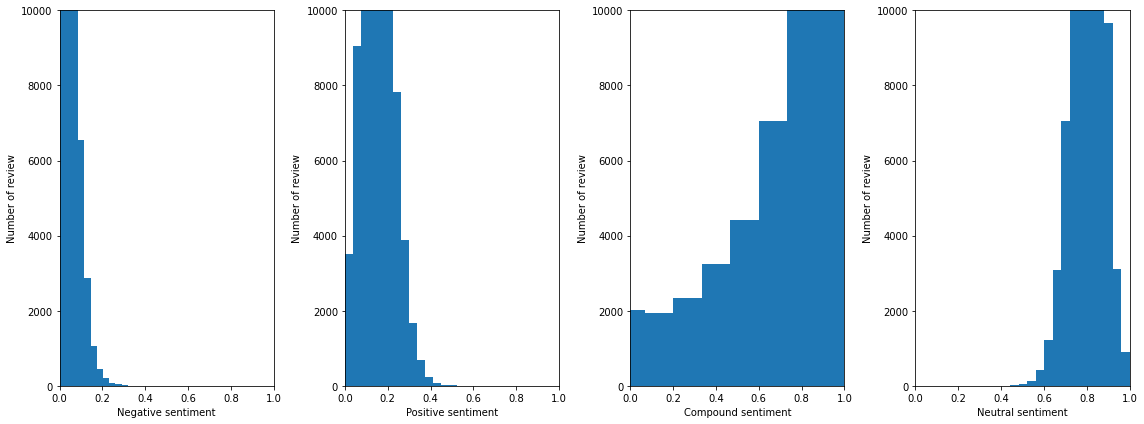

In [16]:
plt.close('all')
fig = plt.figure(figsize=(16,6))

ax1 = plt.subplot(141)
ax2 = plt.subplot(142)
ax3 = plt.subplot(143)
ax4 = plt.subplot(144)

negative_sent = []
[negative_sent.append(analyzer.polarity_scores(sent)['neg']) for sent in df_rev_low.review]
ax1.hist(negative_sent,bins=15)
ax1.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Negative sentiment', ylabel = 'Number of review') 

positive_sent = []
[positive_sent.append(analyzer.polarity_scores(sent)['pos']) for sent in df_rev_low.review]
ax2.hist(positive_sent,bins=15)
ax2.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Positive sentiment', ylabel = 'Number of review') 

total_sent = []
[total_sent.append(analyzer.polarity_scores(sent)['compound']) for sent in df_rev_low.review]
ax3.hist(total_sent,bins=15)
ax3.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Compound sentiment', ylabel = 'Number of review') 

neutre_sent = []
[neutre_sent.append(analyzer.polarity_scores(sent)['neu']) for sent in df_rev_low.review]
ax4.hist(neutre_sent,bins=15)
ax4.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Neutral sentiment', ylabel = 'Number of review') 

plt.tight_layout()

In [95]:
df_rev_low_sco = df_rev_low.loc[df_rev_low['location'] == 'Scotland',:]
df_rev_low_wal = df_rev_low.loc[df_rev_low['location'] == 'Wales',:]
df_rev_low_noir = df_rev_low.loc[df_rev_low['location'] == 'Northern Ireland',:]

[(0.0, 1.0),
 (0.0, 10000.0),
 Text(0.5, 0, 'Negative sentiment Northern Ireland'),
 Text(0, 0.5, 'Number of review gabon')]

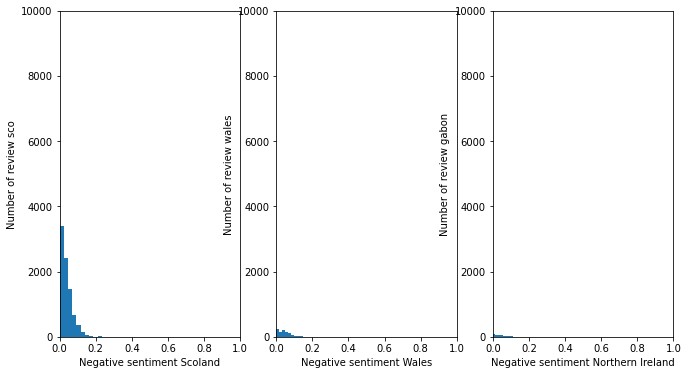

In [99]:
plt.close('all')
fig = plt.figure(figsize=(11,6))

ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

negative_sent = []
[negative_sent.append(analyzer.polarity_scores(sent)['neg']) for sent in df_rev_low_sco.review]
ax1.hist(negative_sent,bins=15)
ax1.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Negative sentiment Scoland', ylabel = 'Number of review sco') 

negative_sent = []
[negative_sent.append(analyzer.polarity_scores(sent)['neg']) for sent in df_rev_low_wal.review]
ax2.hist(negative_sent,bins=15)
ax2.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Negative sentiment Wales', ylabel = 'Number of review wales') 

negative_sent = []
[negative_sent.append(analyzer.polarity_scores(sent)['neg']) for sent in df_rev_low_noir.review]
ax3.hist(negative_sent,bins=15)
ax3.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Negative sentiment Northern Ireland', ylabel = 'Number of review gabon') 




[(0.0, 1.0),
 (0.0, 10000.0),
 Text(0.5, 0, 'Positive sentiment Northern Ireland'),
 Text(0, 0.5, 'Number of review Northern Ireland')]

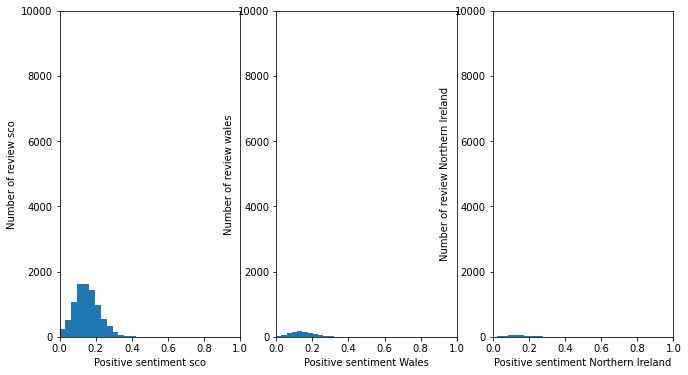

In [101]:
plt.close('all')
fig2 = plt.figure(figsize=(11,6))

ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

positive_sent = []
[positive_sent.append(analyzer.polarity_scores(sent)['pos']) for sent in df_rev_low_sco.review]
ax1.hist(positive_sent,bins=15)
ax1.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Positive sentiment sco', ylabel = 'Number of review sco') 

positive_sent=[]
[positive_sent.append(analyzer.polarity_scores(sent)['pos']) for sent in df_rev_low_wal.review]
ax2.hist(positive_sent,bins=15)
ax2.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Positive sentiment Wales', ylabel = 'Number of review wales') 

positive_sent=[]
[positive_sent.append(analyzer.polarity_scores(sent)['pos']) for sent in df_rev_low_noir.review]
ax3.hist(positive_sent,bins=15)
ax3.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Positive sentiment Northern Ireland', ylabel = 'Number of review Northern Ireland') 

[(0.0, 1.0),
 (0.0, 10000.0),
 Text(0.5, 0, 'Neutral sentiment Northern Ireland'),
 Text(0, 0.5, 'Number of review Northern Ireland')]

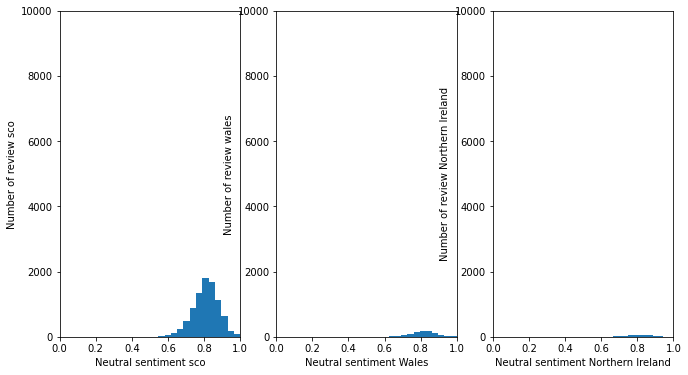

In [105]:
plt.close('all')
fig2 = plt.figure(figsize=(11,6))

ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

neutre_sent = []
[neutre_sent.append(analyzer.polarity_scores(sent)['neu']) for sent in df_rev_low_sco.review]
ax1.hist(neutre_sent,bins=15)
ax1.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Neutral sentiment sco', ylabel = 'Number of review sco') 

neutre_sent=[]
[neutre_sent.append(analyzer.polarity_scores(sent)['neu']) for sent in df_rev_low_wal.review]
ax2.hist(neutre_sent,bins=15)
ax2.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Neutral sentiment Wales', ylabel = 'Number of review wales') 

neutre_sent=[]
[neutre_sent.append(analyzer.polarity_scores(sent)['neu']) for sent in df_rev_low_noir.review]
ax3.hist(neutre_sent,bins=15)
ax3.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Neutral sentiment Northern Ireland', ylabel = 'Number of review Northern Ireland') 